<a href="https://colab.research.google.com/github/christianluer/Bases_de_datos_g80/blob/master/Tarea_4__Redes_neuronales_y_aprendizaje_reforzado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> Nombre: Christian</H1>
<H1> Apellido: Luer</H1>
<H1> Número de alumno: 17642051</H1>

#Códigos de la Actividad de ANN

In [ ]:
%%bash
gdown --id 1Lg3Bsw4tFqye2rsentjLVK7eUw2qLLD3
unzip -q mini_mpii.zip
rsync -a valid/ train/
rsync -a test/ train/
rm -r valid/ test/
mv train/ miniMPII/

Downloading...
From: https://drive.google.com/uc?id=1Lg3Bsw4tFqye2rsentjLVK7eUw2qLLD3
To: /content/mini_mpii.zip
236MB [00:01, 145MB/s]


In [ ]:
!pip install openpifpaf==0.10.1 #última versión estable conocida

In [ ]:
import openpifpaf
print("Versión actual de openpifpaf:", openpifpaf.__version__)

Versión actual de openpifpaf: 0.10.1


In [ ]:
#@title Carga y preparación de la red
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("usando " + "GPU" if use_cuda else "CPU")
oppnet, _ = openpifpaf.network.factory(checkpoint='resnet50')
oppnet = oppnet.to(device)
decode = openpifpaf.decoder.factory_decode(oppnet, 
                                           seed_threshold=0.5)
processor = openpifpaf.decoder.Processor(oppnet, decode, 
                                         instance_threshold=0.2,
                                         keypoint_threshold=0.3)

usando GPU


In [ ]:
#@title Dataset class { form-width: "10px" }
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np 
from PIL import Image
import csv
import cv2
import random
import sys

class PosesDataset(Dataset): #Clase dataset
    def __init__(self, path, oppnet, device): #Preprocesamos las imágenes con PifPaf para obtener el esqueleto
        self.classes = sorted(os.listdir(path))
        self.classesid = {class_nom : id for (id, class_nom) in enumerate(self.classes)}
        self.length_dataset = 0
        self.skeletons = []
        self.labels = []
        self.device = device
        self.bads_route = []

        for classdir in self.classes:
            samples = os.listdir(path + '/' + classdir)
            self.length_dataset += len(samples) #Actualizamos la cantidad de imágenes del dataset

        trim_ab = np.array([[1, 0], [0, 1], [0, 0]]) #para que solo las dos primeras columnas entren en el cálculo del centro de masa
        trim__c = np.array([[0], [0], [1]]) #para extraer tan solo la tercera columna en el cálculo matricial
        current = 0
        bad = 0

        for classdir in self.classes: #Bucar en cada clase
            samples = os.listdir(path + '/' + classdir)
            samples = sorted(samples)

            for sample in samples: #Cargar cada imagen de una clase en una lista o diccionario
                route = path + '/' + classdir + '/' + sample
                img = Image.open(route)
                width, height = img.size
                if width != 640 or height != 480:
                      img = img.resize((640, 480), resample=Image.BILINEAR)

                data = openpifpaf.datasets.PilImageList([img]) #Procesamos las imágenes en un minibatch que puede ser de largo variable
                loader = DataLoader(data, batch_size=1, pin_memory=True)

                curr = 0
                for images_batch, _, __ in loader:
                    curr += 1
                    images_batch = images_batch.to(device)
                    fields_batch = processor.fields(images_batch)
                    keypoint_sets, scores = processor.keypoint_sets(fields_batch[0])
                if curr > 1:
                    print('batch mayor a uno')

                width, height = 640, 480
                cm_img = np.array([[width/2, height/2]]) #Centro de masa según el tamaño actual
                distances = []
                mass_centers = []
                threshold = 0.5 #umbral de los puntos c de los que PifPaf no está seguro

                for skeleton in keypoint_sets:
                    cm_calc = np.around(skeleton.dot(trim__c)) #Mirando únicamente la tercera columna
                    cm_calc = (np.abs(cm_calc) >= threshold).astype(float) #Usando solo los más representativos (para que los que son cero no entren en el cálculo del centro de masa)
                    cm_calc = cm_calc/sum(cm_calc) #Matriz que calcula el centro de masa
                    cm_calc = cm_calc.transpose() #necesitamos transponer para multiplicar por la izquierda
                    cm = cm_calc.dot(skeleton).dot(trim_ab) #centro de masa de los puntos visibles
                    mass_centers.append(cm)
                    dist = np.linalg.norm(cm - cm_img)
                    distances.append(dist)
                    
                current += 1 #agregamos una imagen a la cuenta

                msj = "Sampling images in {} {:.2f}% complete".format(path, current/self.length_dataset*100)
                for i in range(len(msj)):
                    sys.stdout.write('\r')
                sys.stdout.write(msj)

                if len(distances) > 0:
                    index = np.argmin(np.array(distances)) #índice del esqueleto más centrado en la foto
                    label = self.classesid[classdir]
                    self.skeletons.append(keypoint_sets[index]) 
                    self.labels.append(label)
                else: #Como parte de la metodología hay imágenes que el software no puede guardar bien, pero están en el dataset. Estas se guardan.
                    self.skeletons.append(- torch.ones((17, 3))) 
                    self.labels.append(classesid[classdir])
                    self.bads_route.append(route)
                    bad += 1

        print(" ")
        if (bad > 0):
            print("Warning: there are {} images that PifPaf could not recognize, {:.2f}% of the total".format(bad, bad/current*100))

    def get_tags(self, idx=-1):
        if idx == -1:
            return list(self.classesid.keys())
        else:
            return self.classes[idx]

    def get_class_num(self, idx):
        return self.classesid[idx]

    def __getitem__(self, idx):
        skeleton = torch.tensor(self.skeletons[idx], requires_grad=True)
        label = torch.tensor(self.labels[idx])

        return skeleton.to(self.device).view(17*3), label.to(self.device)        

    def __len__(self):
        return self.length_dataset

In [ ]:
#@title Carga del dataset
import time
import datetime
batch_size = 1
start = time.time()
train_set = PosesDataset('miniMPII', processor, device)
# valid_set = PosesDataset('valid', processor, device)
# test_set = PosesDataset('test', processor, device)
loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
stop = time.time()
print("Loading time = ", datetime.timedelta(seconds=int(stop-start)))

Sampling images in miniMPII 100.00% complete 
Loading time =  0:01:14


¿Cuáles serían las clases de este set de datos?

In [ ]:
print(train_set.get_tags())

['bicycling', 'cooking', 'rope_skipping', 'washing_car']


Despleguemos un ejemplo de cada clase

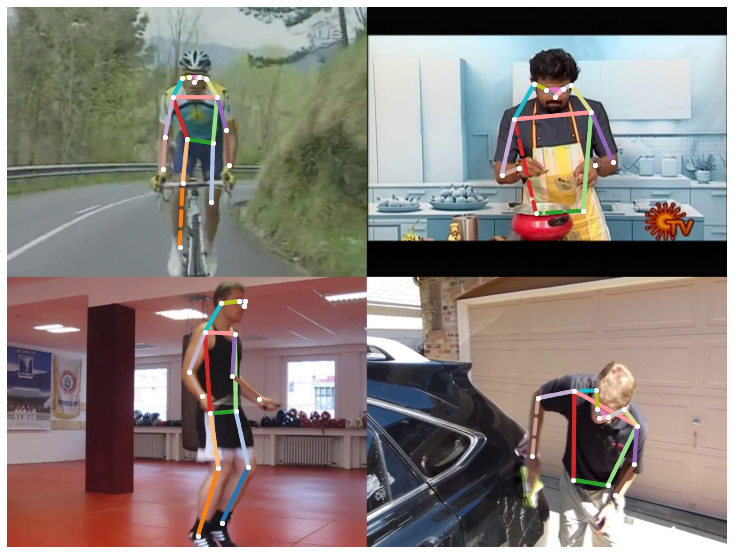

In [ ]:
import random
path = 'miniMPII'
classes = sorted(os.listdir(path))
classesid = {class_nom : id for (id, class_nom) in enumerate(classes)}

for (i, classdir) in enumerate(classes):
    samples = os.listdir(path + '/' + classdir)
    sampled = path + '/' + classdir + '/' + random.choice(samples)
    img_bgr = cv2.imread(sampled)
    height, width, channels = img_bgr.shape
    img_bgr = cv2.resize(img_bgr, (640, 480), interpolation=cv2.INTER_AREA)

    if i%2 == 0:
        row = img_bgr
    else:
        row = np.concatenate((row, img_bgr), axis=1)
        if i == 1:
            all_sampled = row
        else:
            all_sampled = np.concatenate((all_sampled, row), axis=0)

all_sampled = cv2.cvtColor(all_sampled, cv2.COLOR_BGR2RGB)
collage = Image.fromarray(all_sampled)
data = openpifpaf.datasets.PilImageList([collage])
miniloader = torch.utils.data.DataLoader(data, batch_size=1, pin_memory=True)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=4)

for images_batch, _, __ in miniloader:
  images_batch = images_batch.cuda()
  fields_batch = processor.fields(images_batch)
  predictions = processor.annotations(fields_batch[0])
  keypoint_sets, scores = processor.keypoint_sets(fields_batch[0])
  
  with openpifpaf.show.image_canvas(collage) as ax:
    keypoint_painter.annotations(ax, predictions)

In [ ]:
for (data, labels) in loader:
    x_row = data.cpu().detach().numpy()
    y_row = labels.cpu().detach().numpy()
    print(x_row)
    print(y_row)
    break

[[311.50024    147.84064      0.86866796 323.59946    133.48622
    0.8780707  297.16238    136.6774       0.8739884  347.3995
  129.78432      0.8890664  282.96127    134.48743      0.75314164
  397.52902    183.6155       0.93531597 260.81686    194.47932
    0.83504444 431.61105    267.40738      0.96080613 195.89856
  283.3878       0.8043533  380.87396    274.33743      1.
  234.58736    257.98532      0.820682   376.23654    371.83563
    0.6591763  287.69632    356.91714      0.61162513   0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]]
[1]


#Códigos de la Actividad de AR

In [ ]:
#Descarga del ambiente (RUN ME!)
%%bash
pip install gym pyvirtualdisplay > /dev/null 2>&1
apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
apt-get update > /dev/null 2>&1
apt-get install cmake > /dev/null 2>&1
pip install --upgrade setuptools 2>&1
pip install ez_setup > /dev/null 2>&1
pip install gym[atari] > /dev/null 2>&1

In [ ]:
#@title Importes (RUN ME TOO!)
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Vamos a inicializar el ambiente

In [ ]:
env = gym.make('CartPole-v1')

Cada vez que se resetea el ambiente se envía una observación del estado en el que inicia la nueva instancia.

In [ ]:
obs = env.reset()
print(obs)

Estos son los estados de ciertas variables importantes, para el ambiente. En ese caso estamos utilizando el ambiente ```CartPole-v1```. Según la [wiki](https://github.com/openai/gym/wiki/CartPole-v0) del toolkit las observaciones del sistema son: <p>

>Num | Observations | Min | Max
>--- | --- | ---  | ---
>0 | Cart Position | -2.4 | 2.4
>1 | Cart Velocity | -Inf | Inf
>2 | Pole Angle | ~-41.8° | ~41.8°
>3 | Pole Velocity at tip | -Inf | Inf


In [ ]:
print('Su espacio de acciones es', env.action_space)

En pocas palabras

>Num | Action
>--- | --- 
>0 | Push car to left
>1 | Push car to right

Cada vez que se carga el ambiente se inicializa en algún estado aleatorio, con el péndulo en posición vertical. Veamos dos ejemplos.

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'));

In [ ]:
env.reset()
plt.imshow(env.render(mode='rgb_array'));

La diferencia es sutil, esto pues este ambiente tiene un desafío como diseño. Hay que mantener el péndulo vertical tanto como se pueda. Luego de eso el ambiente termina. <br>
Ambientes como éste se denominan episódicos. Y tienden a funcionar en series de episodios. Muchos juegos caen en esta categoría, juegos de atari como pacman, o incluso juegos analógicos como el ajedrés también son episódicos.<br>
Los episodios de este ambiente terminan si:


*   El ángulo del péndulo es mayor a $\pm 12°$
*   La posición del carro es mayor a $\pm 2.4$
*   El largo del episodio es mayor a 500



Cada ambiente puede enviar una secuencia de acciones aleatorias si se le desea.

In [ ]:
[env.action_space.sample() for _ in range(10)]

Calculemos cuantas acciones de "ir a la izquierda" puede tomar en promedio el sistema antes de que termine el episodio.

In [ ]:
def actions_till_done(env, action):
    env.reset()
    done = False
    count = 0
    while done == False:
        _, _, done, _, = env.step(action)
        count += 1
    return count
  
# Get an estimate for how many 0 actions you can take on average before the 
# pole falls over
np.mean([actions_till_done(env, 0) for _ in range(100)])

De la misma manera se puede definir un criterio que calcule la cantidad de recompensas que se pueden obtener por episodio en promedio.

In [ ]:
def average_episodic_return(env, agent, episodes=10, max_steps_per_episode=500):
    episode_rewards = []
    for episode in range(episodes):
        total_rewards = 0
        obs = env.reset()
        for t in range(max_steps_per_episode):
            out = agent(obs) # we don't care about the probabilities here
            assert ("Action" in out), "The key 'Action' was missing from the agents output."
            obs, rew, done, _ = env.step(out["Action"])
            total_rewards += rew
            # check if we are done, if so, exit loop
            if done:
                break
                
        episode_rewards.append(total_rewards)
        
    return {
        "AverageEpisodicReturn": np.mean(episode_rewards), 
        "StandardDeviation":np.sqrt(np.var(episode_rewards))
    }

In [ ]:
def agent_left(observation):
    return {"Action":0}

In [ ]:
average_episodic_return(env, agent_left)

De la misma forma que pudimos mostrar una imagen de un estado del agente se puede presentar al agente en una secuencia animada.

In [ ]:
from collections import deque
import matplotlib.animation
import matplotlib.pyplot as plt
%matplotlib inline

def animate_agent(env, agent, max_steps = 400):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
            
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

¿Cómo se ve el agente cuando se le da la orden de ir siempre a la izquierda?

In [ ]:
def agent_left(observation):
    return {"Action":0}
  
animate_agent(env, agent_left, max_steps = 400)

¿Y si se envía una orden aleatoria para que se mueva a izquierda o derecha?

In [ ]:
def agent_random(observation):
    return {"Action":np.random.choice([0, 1])}

In [ ]:
average_episodic_return(env, agent_random)

In [ ]:
animate_agent(env, agent_random)

Intentemos entrenar el agente utilizando Value Iteration.

In [ ]:
def state_for(observation):
    ranges = [np.arange(-1, 1.25, 0.25), np.arange(-0.3, 0.375, 0.075)[:9], np.arange(-1, 1.25, 0.25)]
    state = np.zeros((3,)) #Ignorando el primer sensor
    for i, (obs, limits) in enumerate(zip(observation[1:], ranges)):
        if obs < limits[0]:
            state[i] = 0
            continue
        for j in range(1, len(limits) - 1):
            if limits[j] <= obs <= limits[j+1]:
                state[i] = j
                break
        if obs > limits[len(limits) - 1]:  
            state[i] = len(limits)

    currstate = 0

    for i in range(3): 
        currstate += state[i] * (10 ** i)

    return int(currstate)


#Actividad 1

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np

In [ ]:
#df = pd.DataFrame()
x = np.empty((0,51), int)
y = np.empty((0),int)
for (data, labels) in loader:
  x_row = data.cpu().detach().numpy()
  y_row = labels.cpu().detach().numpy()
  x = np.append(x, np.array(x_row), axis=0)
  y = np.append(y, np.array(y_row), axis=0)
  #a_row = pd.Series([x_row, y_row])
  #row_df = pd.DataFrame([a_row])
  #df = pd.concat([df, row_df], ignore_index=True)

In [ ]:
x.shape

(485, 51)

In [ ]:
y.shape

(485,)

In [ ]:
### normalizacion
x_norm = x.copy()

for (i,x) in enumerate(x_norm):
  x_min = min(x)
  x_max = max(x)
  x_norm[i] = (x-x_min)/(x_max-x_min)

In [ ]:
x_norm
from sklearn.model_selection import train_test_split

In [ ]:
x_norm_train, x_norm_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.1)

In [ ]:
x_norm_train.shape

(436, 51)

In [ ]:
mlp = Sequential()
mlp.add(Dense(10, input_shape=(436, 51,None,51),activation="relu"))
mlp.add(Dense(40, activation="sigmoid"))
mlp.add(Dense(20, activation="tanh"))
mlp.add(Dense(4, activation="softmax"))
#mlp.add(Dense(4, activation="softmax"))

In [ ]:
mlp.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 436, 51, None, 10) 520       
_________________________________________________________________
dense_62 (Dense)             (None, 436, 51, None, 40) 440       
_________________________________________________________________
dense_63 (Dense)             (None, 436, 51, None, 20) 820       
_________________________________________________________________
dense_64 (Dense)             (None, 436, 51, None, 4)  84        
Total params: 1,864
Trainable params: 1,864
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.utils import to_categorical

In [ ]:
mlp.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
min_y = int(min(y))
max_y = int(max(y))
num_clases = max_y - min_y + 1
print(f"hay {num_clases} clases")



hay 4 clases


In [ ]:
y_train_onehot = to_categorical(y_train, num_clases)
Y_test_onehot = to_categorical(y_test, num_clases)

In [ ]:
y_train_onehot.shape

(436, 4)

In [ ]:
len(x_norm_train)

436

In [ ]:
mlp.fit(x_norm_train, y_train_onehot, epochs=40, batch_size=32,  verbose=1, validation_split=.2)

Epoch 1/40
11/11 [==============================] - 0s 17ms/step - loss: 1.6082 - accuracy: 0.1753 - val_loss: 1.4152 - val_accuracy: 0.2045
Epoch 2/40
11/11 [==============================] - 0s 4ms/step - loss: 1.3970 - accuracy: 0.3075 - val_loss: 1.3812 - val_accuracy: 0.2955
Epoch 3/40
11/11 [==============================] - 0s 4ms/step - loss: 1.3573 - accuracy: 0.3161 - val_loss: 1.3645 - val_accuracy: 0.2955
Epoch 4/40
11/11 [==============================] - 0s 4ms/step - loss: 1.3333 - accuracy: 0.3161 - val_loss: 1.3420 - val_accuracy: 0.3295
Epoch 5/40
11/11 [==============================] - 0s 4ms/step - loss: 1.3220 - accuracy: 0.3506 - val_loss: 1.3315 - val_accuracy: 0.3182
Epoch 6/40
11/11 [==============================] - 0s 5ms/step - loss: 1.3128 - accuracy: 0.3305 - val_loss: 1.3222 - val_accuracy: 0.3636
Epoch 7/40
11/11 [==============================] - 0s 4ms/step - loss: 1.3011 - accuracy: 0.4195 - val_loss: 1.3114 - val_accuracy: 0.4318
Epoch 8/40
11/11 [=

#Pregunta 2

#Pregunta 3

#Pregunta 4

#Pregunta 5

#Pregunta 6